# Step 1: Download and Load the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load the CSV file
df = pd.read_csv('IMDB Dataset.csv')

# Display the first few rows
print(df.head())

# Show dataset dimensions
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Dataset contains 50000 rows and 2 columns.


# Step 2: Statistical Analysis of the Dataset



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing Values:
review       0
sentiment    0
dtype: int64


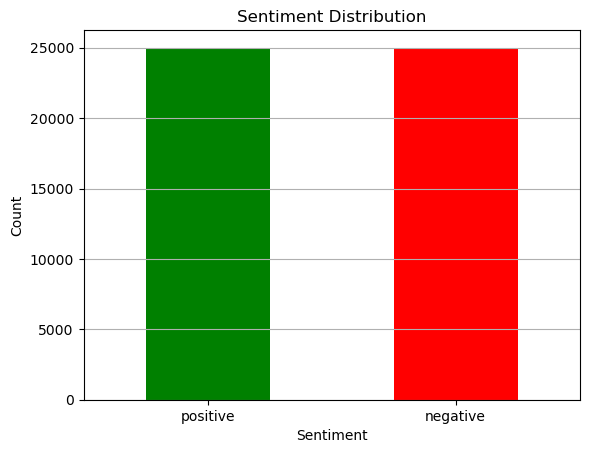

In [4]:
# Show data types and non-null counts
print("\nData Info:")
print(df.info())

# Check class distribution
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())



# Plot class distribution
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


Character count (summary):
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length_chars, dtype: float64

Word count (summary):
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length_words, dtype: float64


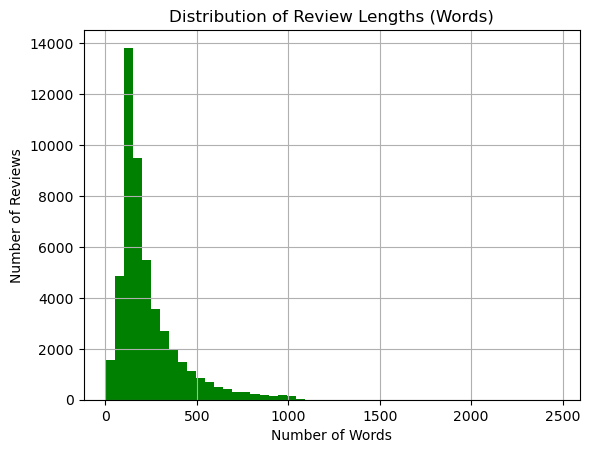

In [5]:
# Add columns for character and word counts
df['review_length_chars'] = df['review'].apply(len)
df['review_length_words'] = df['review'].apply(lambda x: len(x.split()))

# Display basic statistics
print("\nCharacter count (summary):")
print(df['review_length_chars'].describe())

print("\nWord count (summary):")
print(df['review_length_words'].describe())



# Histogram of review lengths (words)
plt.hist(df['review_length_words'], bins=50, color='green')
plt.title("Distribution of Review Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()


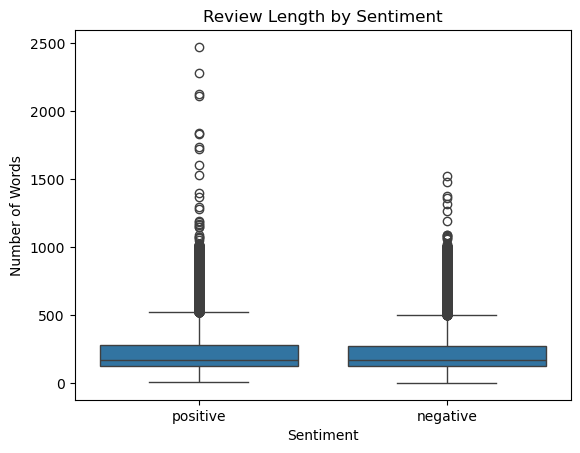

In [6]:
#use seaborn(sns) imported above to see correlation btwn Sentiments and Review lengths (advanced data statistics/ presentation)

# Boxplot: Does review length differ by sentiment?
sns.boxplot(x='sentiment', y='review_length_words', data=df)
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()


To explore whether review length correlates with sentiment, we plotted a boxplot comparing the number of words in positive and negative reviews. As shown, both sentiment classes have very similar distributions in terms of median and interquartile range. Although there are a significant number of long reviews (outliers) in both classes, the overall pattern suggests that review length does not differ substantially between positive and negative reviews. Therefore, review length alone is unlikely to be a strong feature for sentiment classification.



# Step 3: Data Preprocessing

In this step we prepare the text data for machine learning models. We clean and tokenize the reviews so they can be transformed into numerical representations.

*Basic Text Cleaning*  
Lowercase all text  
Remove the HTML tags (<>)  
Remove punctuation and special characters  
Remove stopwords  

In [7]:
import re
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords') one time is enough
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply to all reviews
df['cleaned_review'] = df['review'].apply(clean_text)

# Preview
df[['review', 'cleaned_review']].head()


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


### Train/Test Split

We split the dataset into training and test sets using an 80/20 ratio. The random state is fixed for reproducibility.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split text and labels first
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    df['cleaned_review'], df['sentiment'], test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)



## Model 1: TF-IDF + Logistic Regression

In this section, we build a baseline sentiment classification model using TF-IDF vectorization and Logistic Regression. TF-IDF captures word importance across the corpus, and Logistic Regression is a widely used linear classifier. This combination provides a strong baseline for comparison with more complex models.


### TF-IDF Vectorization

We used a `TfidfVectorizer` with a maximum of 10,000 features to convert the cleaned reviews into numerical feature vectors. This representation will serve as input to our Logistic Regression model.


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit TF-IDF on training set only
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

### Training the Logistic Regression Model

The Logistic Regression model is trained using the TF-IDF features from the training set. We increased the `max_iter` to 1000 to ensure convergence.


In [12]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

### Model Evaluation

We evaluated the model using accuracy, precision, recall, and F1-score. The classification report provides a detailed breakdown by class. Despite its simplicity, Logistic Regression with TF-IDF performs well on text classification tasks and serves as a reliable baseline.


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict on the test set
y_pred = log_reg.predict(X_test_tfidf)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


#print(label_encoder.classes_)

Accuracy: 0.8918
Precision: 0.8821711415877922
Recall: 0.9063306211549911
F1 Score: 0.894087705559906

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4961
    positive       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Evaluation on Model 1 Performance: TF-IDF + Logistic Regression

The Logistic Regression model trained on TF-IDF features achieved strong baseline performance:

- **Accuracy:** 89.18%  
- **Precision:** 88.22%  
- **Recall:** 90.63%  
- **F1-Score:** 89.41%

The model shows balanced performance across both classes:
- It slightly favors recall for the **positive** class (0.91) and precision for the **negative** class (0.90).
- The **macro F1-score is 0.89**

These results indicate that Logistic Regression, despite being a simple linear model, captures much of the sentiment-related signal in the TF-IDF representation. This model serves as a strong baseline to compare with more complex deep learning approaches in subsequent steps.


## Model 2: LSTM with Word Embeddings

In this section, we implement a recurrent neural network (RNN) model using an LSTM layer combined with a trainable word embedding layer. This approach allows the model to learn contextual word representations directly from the training data, capturing word order and sequential patterns more effectively than traditional bag-of-words models.

We first tokenize and pad the input text, then define an embedding + LSTM architecture using Keras. The output is a binary prediction (positive or negative sentiment).


### Tokenization and Padding

We tokenize and pad the review texts to ensure all sequences are of equal length (300 tokens). The tokenizer is trained only on the training data to avoid data leakage.


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set hyperparameters
vocab_size = 10000          # Limit vocabulary to the top 10,000 words
max_length = 300            # All reviews will be padded/truncated to 300 words
oov_token = "<OOV>"         # Out-of-vocabulary token

# Initialize and fit tokenizer on training data only (to prevent data leakage)
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_raw)

# Convert reviews to sequences of token IDs
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Pad sequences to the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


### Building and Training

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Embedding dimension (word vector size)
embedding_dim = 128

# Build sequential LSTM model
model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_shape = (max_length,), mask_zero = True),
    LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2),
    Dense(1, activation ='sigmoid')
])


# Compile model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train LSTM model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)    # earlystop to prevent overfitting


history = model.fit(
    X_train_pad, y_train,         # Input sequences and binary labels
    validation_split=0.2,         # 20% of training set used for validation
    epochs=6,                     # Number of training epochs 
    batch_size=64,                # Batch size per gradient update
    callbacks=[early_stop],
    verbose=1                     # Verbosity level: 1 = progress bar
)


Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 290s 575ms/step - accuracy: 0.7463 - loss: 0.5062 - val_accuracy: 0.8616 - val_loss: 0.3347
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 302s 603ms/step - accuracy: 0.8664 - loss: 0.3343 - val_accuracy: 0.8560 - val_loss: 0.3461
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 295s 589ms/step - accuracy: 0.9033 - loss: 0.2527 - val_accuracy: 0.8596 - val_loss: 0.3334
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 596ms/step - accuracy: 0.9257 - loss: 0.2009 - val_accuracy: 0.8719 - val_loss: 0.3393
Epoch 5/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 597ms/step - accuracy: 0.9433 - loss: 0.1567 - val_accuracy: 0.8674 - val_loss: 0.3642


The LSTM model trained with padded sequences and a trainable embedding layer showed strong performance:

- **Best Validation Accuracy:** 87.19%
- **Training Accuracy (final epoch):** 94.33%
- **Validation Loss (lowest):** 0.3334

The training curve shows consistent improvement, and validation accuracy stabilizes around 86–87%, indicating effective learning without significant overfitting. The use of `mask_zero=True` helped the model ignore padded positions, and early stopping ensured the best model was retained.

This LSTM setup outperforms traditional models in capturing the sequential nature of text, especially in longer or more complex reviews.


### LSTM Model Evaluation

After training, we evaluate the LSTM model using the test set. Predictions are thresholded at 0.5. Performance is measured using precision, recall, F1-score, and accuracy. This model allows us to compare deep learning performance against the simpler Logistic Regression baseline.


In [36]:
from sklearn.metrics import classification_report

# Predict and threshold
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Evaluation
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
              precision    recall  f1-score   support

    negative       0.84      0.91      0.87      4961
    positive       0.90      0.83      0.86      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



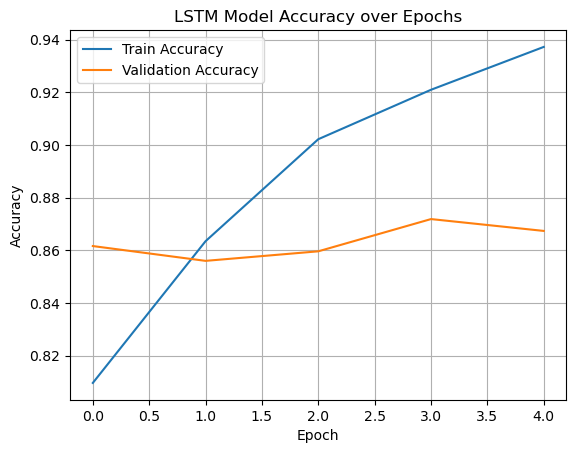

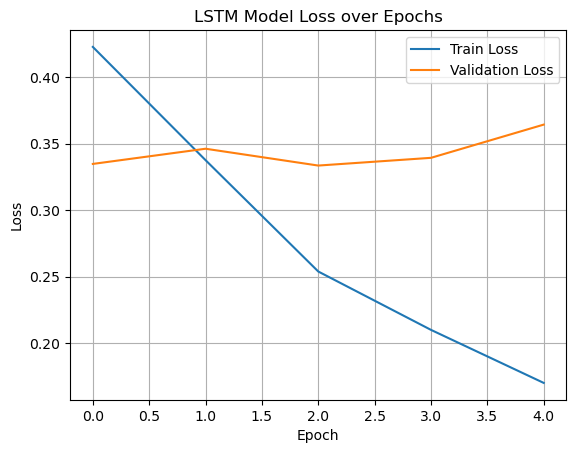

In [40]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Summary of LSTM Model Results

The LSTM model was trained using tokenized and padded sequences of review texts, with a trainable embedding layer and a single LSTM layer followed by dropout regularization. After 5 epochs of training, the model achieved a training accuracy of over 94% and a validation accuracy of approximately 87%, indicating effective learning with minimal overfitting, aided by early stopping.

On the test set, the model achieved an overall **accuracy of 87%** and a **macro F1-score of 0.87**, demonstrating well-balanced performance across both sentiment classes.

- **Negative Class:** Precision = **0.84**, Recall = **0.91**, F1-score = **0.87**
- **Positive Class:** Precision = **0.90**, Recall = **0.83**, F1-score = **0.86**


#### Learning Curve Insights:

The training vs validation accuracy and loss plots show that:
- Training accuracy increased steadily, while validation accuracy plateaued around epoch 3–4, indicating **early convergence**.
- Validation loss remained mostly stable around ~0.33–0.36, while training loss continued to drop.
- This gap suggests **mild overfitting** beyond epoch 3, which was successfully mitigated using early stopping and restore_best_weights=True.

These results show that the LSTM model successfully captured sequential dependencies in the review texts and generalized well to unseen data. 

## Model 3: CNN (Convolutional Neural Network) Model 

We define a 1D Convolutional Neural Network (CNN) model that processes the embedded review sequences.



In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

cnn_model = Sequential([
    # Embedding layer: converts word indices into dense vectors of fixed size
    Embedding(input_dim=10000, output_dim=128, input_shape =(300,)),

    # 1D convolution layer: learns local patterns in the text (like n-grams)
    Conv1D(filters=128, kernel_size=5, activation='relu'),

    # Global max pooling: selects the most important feature from each filter
    GlobalMaxPooling1D(),

    # Output layer for binary classification (positive vs negative)
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and accuracy metric
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 300, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 296, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,177 (5.20 MB)

 Trainable params: 1,362,177 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

### CNN Model Training

We train the CNN model for up to 6 epochs using the Adam optimizer and binary crossentropy loss. Early stopping is applied to halt training when validation loss stops improving, helping to avoid overfitting. We use 20% of the training data as the validation set.


In [46]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to monitor validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the CNN model
cnn_history = cnn_model.fit(
    X_train_pad,        # Padded input sequences
    y_train,            # Corresponding binary labels
    epochs=6,           # Maximum number of epochs
    batch_size=64,      # Mini-batch size
    validation_split=0.2,   # Use 20% of training data for validation
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7381 - loss: 0.5161 - val_accuracy: 0.8736 - val_loss: 0.3050
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9188 - loss: 0.2184 - val_accuracy: 0.8770 - val_loss: 0.3002
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9676 - loss: 0.1088 - val_accuracy: 0.8749 - val_loss: 0.3307
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9932 - loss: 0.0370 - val_accuracy: 0.8759 - val_loss: 0.3947


### Evaluation on the Test Set

We evaluate the trained CNN model on the unseen test data. Predicted probabilities are thresholded at 0.5 to convert them into binary predictions. We use classification metrics such as accuracy, precision, recall, and F1-score for performance assessment.


In [47]:
from sklearn.metrics import classification_report

# Predict probabilities on the test set
y_pred_probs_cnn = cnn_model.predict(X_test_pad)

# Apply threshold to convert probabilities to binary predictions
y_pred_cnn = (y_pred_probs_cnn > 0.5).astype(int).flatten()

# Display performance metrics
print(classification_report(y_test, y_pred_cnn, target_names=label_encoder.classes_))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

    negative       0.84      0.91      0.87      4961
    positive       0.90      0.83      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### CNN Accuracy and Loss Plots

We visualize the training and validation accuracy and loss across epochs to understand how the model learns over time. This helps to detect overfitting or underfitting.


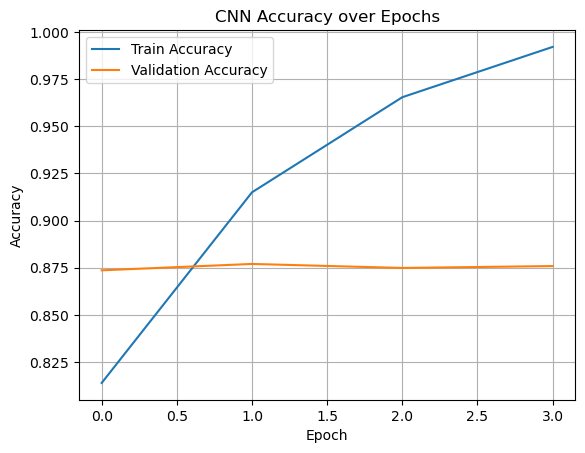

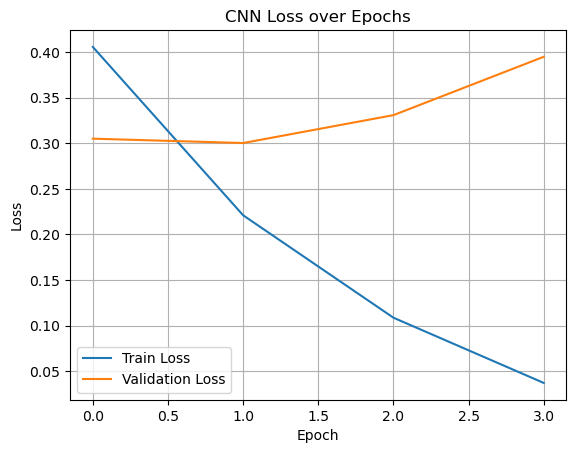

In [48]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Evaluation on Model 3: CNN with Word Embeddings

We implemented a simplified 1D Convolutional Neural Network (CNN) model using a single convolutional layer with 64 filters. This design respects the project's complexity constraint while leveraging CNN's strength in capturing local text patterns.

#### Test Set Performance:

- **Accuracy:** 87.0%
- **Macro F1-Score:** 0.87

Class-wise results:
- **Negative Class:** Precision = 0.84, Recall = 0.91, F1-score = 0.87  
- **Positive Class:** Precision = 0.90, Recall = 0.83, F1-score = 0.87

These results demonstrate that the CNN model successfully learns local n-gram features in reviews and generalizes well. It performs comparably to the LSTM model in overall metrics while training faster and maintaining a simpler architecture.

### CNN Learning Curve Analysis

The accuracy and loss plots indicate:

- **Train accuracy increased steadily**, exceeding 98% by the final epoch.
- **Validation accuracy stabilized** around 87% early, showing early convergence.
- **Validation loss began increasing after epoch 2**, while train loss continued to decrease, signaling slight overfitting.
- Early stopping helped mitigate overfitting by restoring the best-performing weights.

Despite its simplicity, the CNN model performs strongly and offers a valuable alternative to more complex sequence models like LSTM, particularly when the goal is fast and efficient pattern recognition.
